# Advanced Multi-Stage Diabetes Prediction: Comparison with Comprehensive Tuning

**University:** *LIU*  

**Course:** *Intro to AI*  
**Instructor:** *Ghumdan Al-Sabahi*  

**Group Name:** *The Averngers*  

**Group Members:**  
- *Abdulkarem Ghassan* — *62330031*  
- *Baraa Alaa* — *62330034*  
- *Sara Al-Saeedi* — *62330105*  
## 1. Introduction & Project Scope

**Objective:**
Comparison of **Multi-class** vs. **Binary Classification** for diabetes prediction.

**Methodology:**
1.  **Phase 1 (Baseline):** Stratified CV on all models.
2.  **Phase 2 (Tuning):** Hyperparameter Optimization (GridSearchCV) for **ALL** trained models.
3.  **Phase 3 (SMOTE):** Retraining **ALL** tuned models on SMOTE-augmented data.



## 2. Imports & Setup


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, precision_score, recall_score, roc_auc_score, 
    roc_curve, auc
)

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_palette("viridis")
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline



## 3. Utility Functions


In [16]:

def plot_metrics(y_test, y_pred, y_pred_proba, model_name, task='binary'):
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    if y_pred_proba is not None:
        try:
            plt.figure(figsize=(8, 6))
            if task == 'binary':
                # Check for 1D probability array (common in binary scikit models sometimes) or 2D
                if len(y_pred_proba.shape) == 2:
                    probs = y_pred_proba[:, 1]
                else:
                    probs = y_pred_proba
                    
                fpr, tpr, _ = roc_curve(y_test, probs)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            else:
                # Multi-class ROC (One-Vs-Rest)
                classes = np.unique(y_test)
                y_test_bin = label_binarize(y_test, classes=classes)
                n_classes = y_test_bin.shape[1]
                colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
                
                for i, color in zip(range(n_classes), colors):
                    if y_pred_proba.shape[1] > i:
                        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
                        roc_auc = auc(fpr, tpr)
                        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {classes[i]} (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {model_name}')
            plt.legend(loc="lower right")
            plt.show()
        except Exception as e:
            print(f"Could not plot ROC for {model_name}: {e}")


def evaluate_model(y_test, y_pred, y_pred_proba=None, model_name="Model", task='binary', phase="Baseline"):
    accuracy = accuracy_score(y_test, y_pred)
    
    if task == 'binary':
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1]) if y_pred_proba is not None else 0.5
        except:
            roc_auc = 0.5
    else:
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted') if y_pred_proba is not None else 0.5
        except:
            roc_auc = 0.5

    print(f"--- {model_name} [{phase}] ---")
    print(f"Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")
    
    return {
        'Model': model_name,
        'Phase': phase,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc
    }

def get_base_models(random_state=42):
    return {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Naive Bayes': GaussianNB(),
        'KNN': KNeighborsClassifier(n_jobs=-1) 
    }

def get_param_grids(random_state=42):
    # Grids for ALL models
    return {
        'Logistic Regression': {
            'C': [0.1, 1, 10], 
            'solver': ['lbfgs', 'liblinear']
        },
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10]
        },
        'Naive Bayes': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    }



## 4. Data Loading & EDA


Data Loaded: (253680, 22)


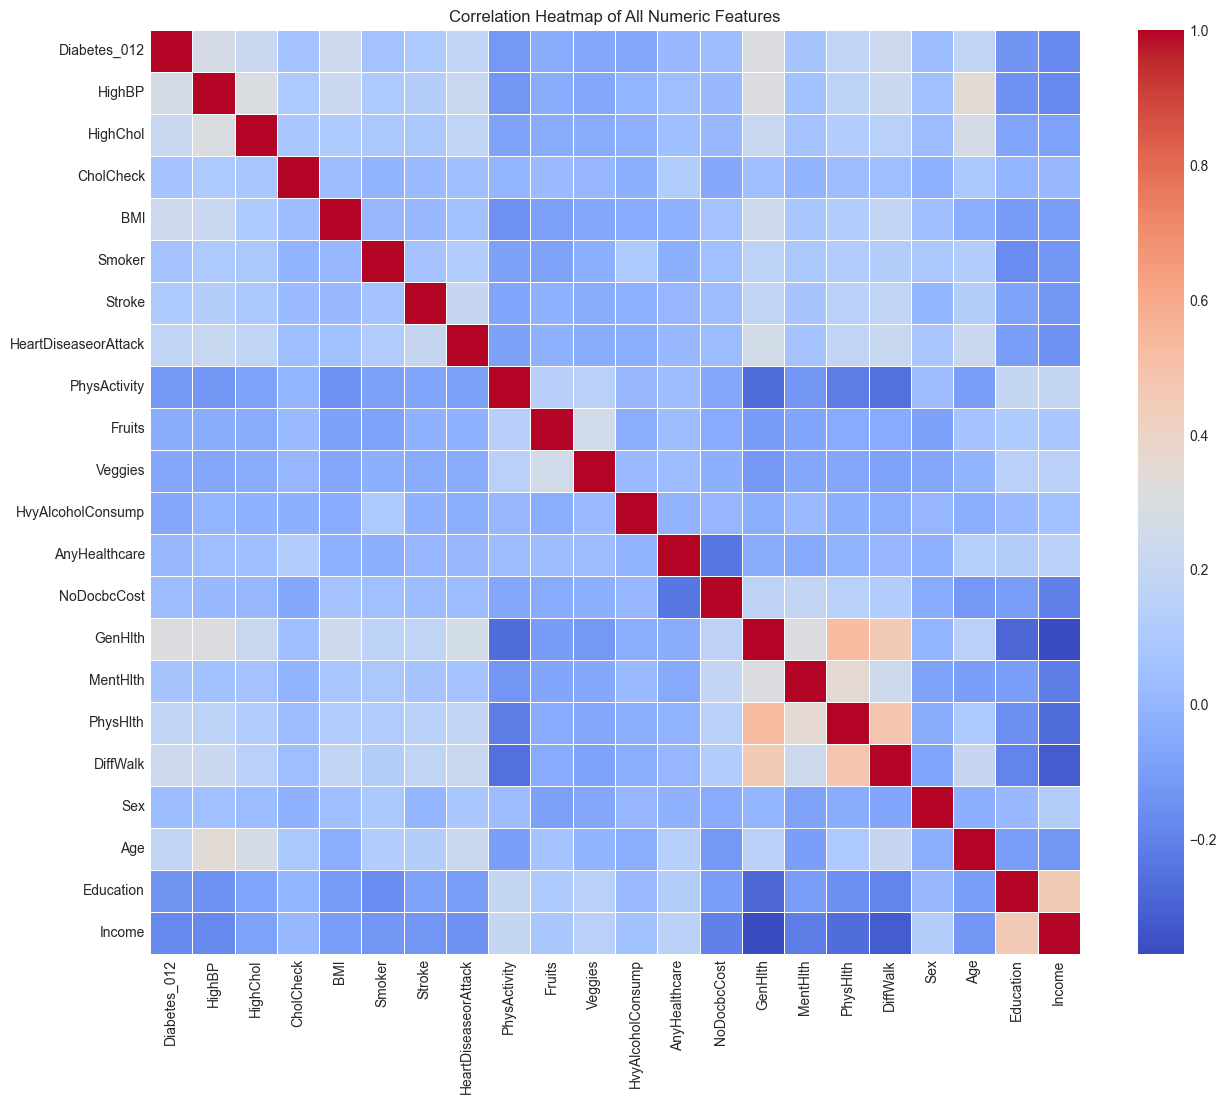

In [17]:
try:
    df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
    print(f"Data Loaded: {df.shape}")
except:
    print("Error loading data.")

# Preprocessing
scaler = StandardScaler()
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


# Visualization: Correlation Heatmap
plt.figure(figsize=(15, 12))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of All Numeric Features')
plt.show()

# Global Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)



# 🏛️ PART A: MULTI-CLASS CLASSIFICATION


In [18]:
full_results_multi = []


## Phase 1: Stratified CV (All Models)


Running Baseline...
--- Logistic Regression [Baseline] ---
Acc: 0.8455 | Prec: 0.7977 | Rec: 0.8455 | F1: 0.8069 | AUC: 0.8138


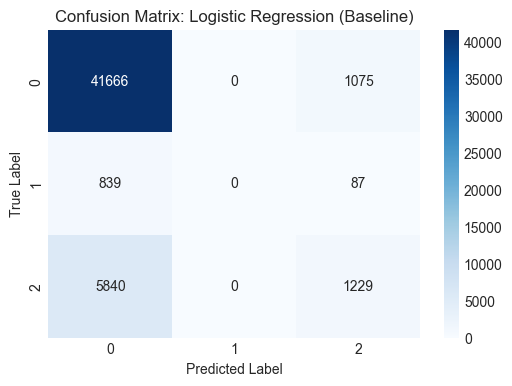

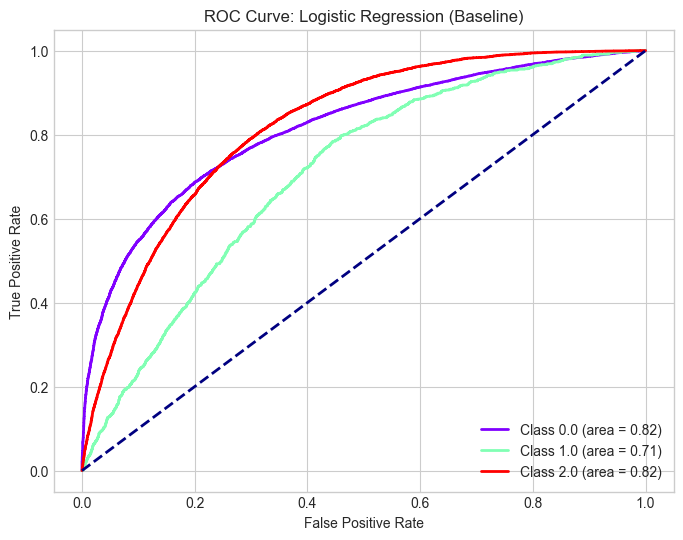

--- Random Forest [Baseline] ---
Acc: 0.8429 | Prec: 0.7972 | Rec: 0.8429 | F1: 0.8088 | AUC: 0.7910


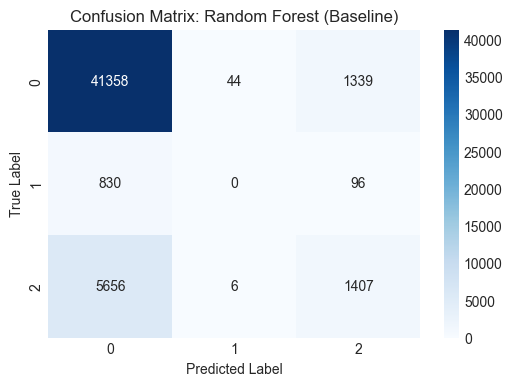

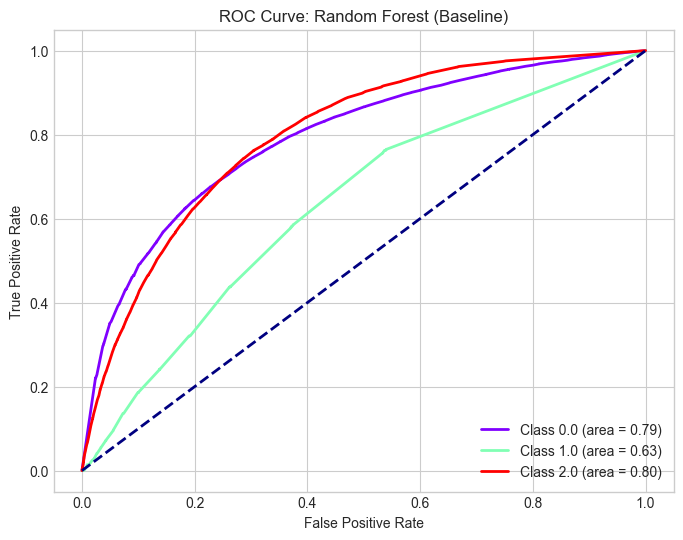

--- XGBoost [Baseline] ---
Acc: 0.8489 | Prec: 0.8044 | Rec: 0.8489 | F1: 0.8119 | AUC: 0.8202


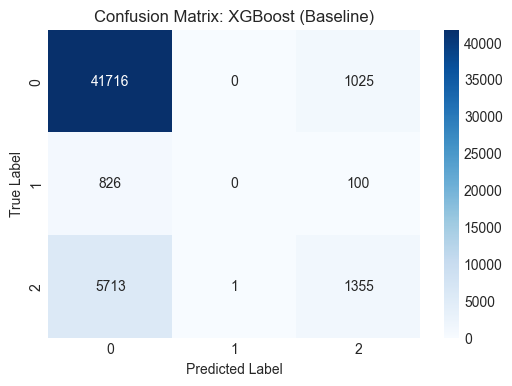

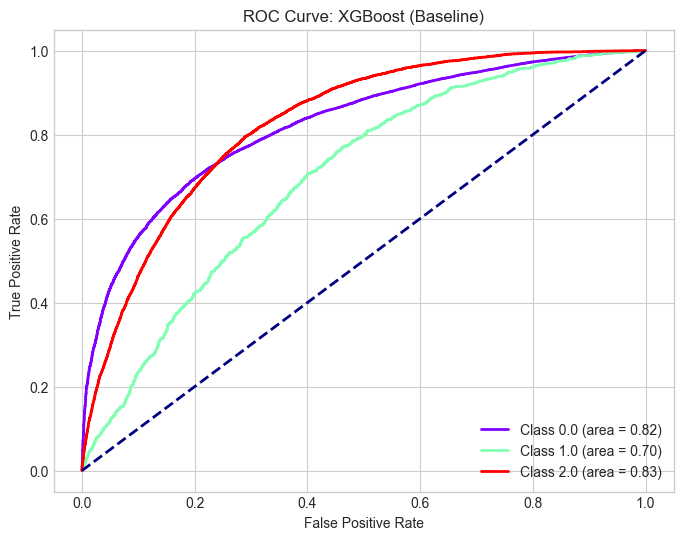

--- Gradient Boosting [Baseline] ---
Acc: 0.8487 | Prec: 0.8040 | Rec: 0.8487 | F1: 0.8116 | AUC: 0.8225


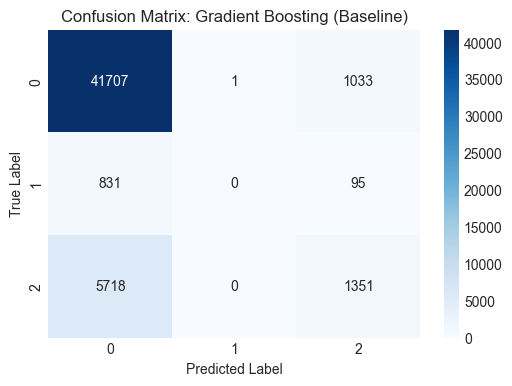

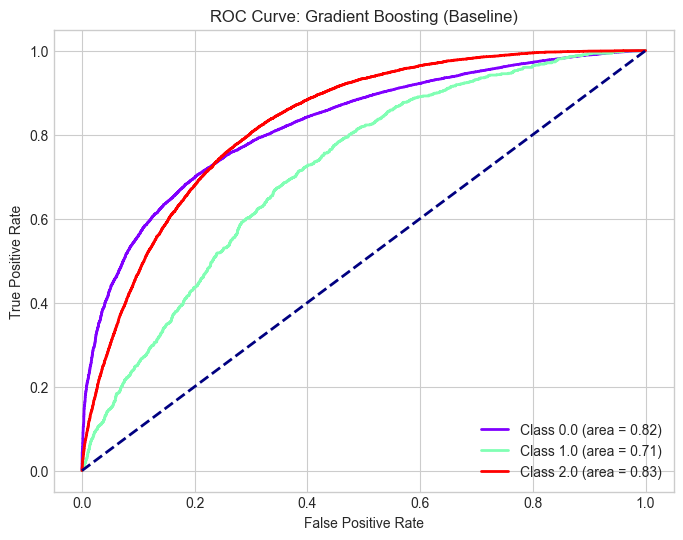

--- Decision Tree [Baseline] ---
Acc: 0.7666 | Prec: 0.7797 | Rec: 0.7666 | F1: 0.7729 | AUC: 0.6019


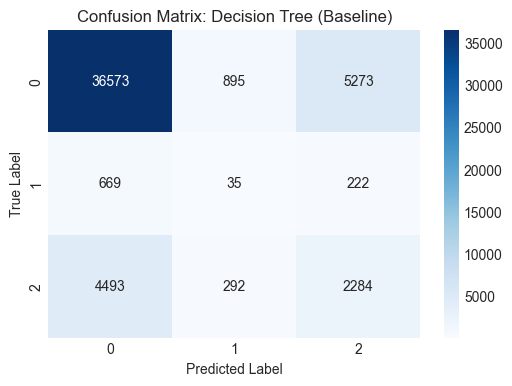

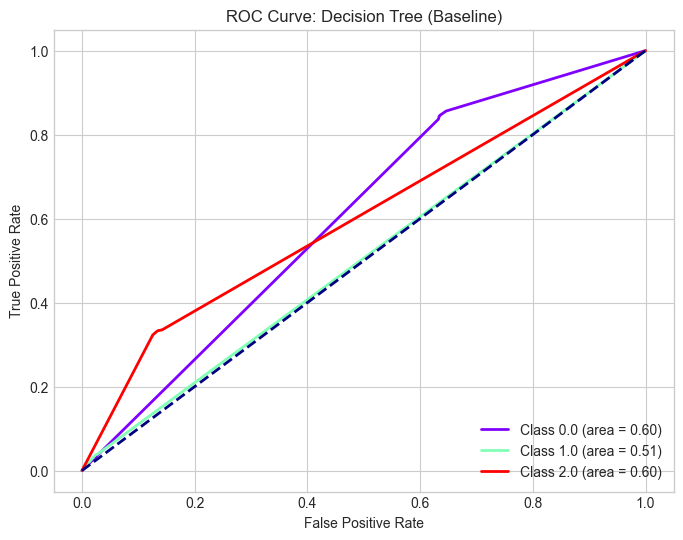

--- Naive Bayes [Baseline] ---
Acc: 0.7579 | Prec: 0.8111 | Rec: 0.7579 | F1: 0.7771 | AUC: 0.7776


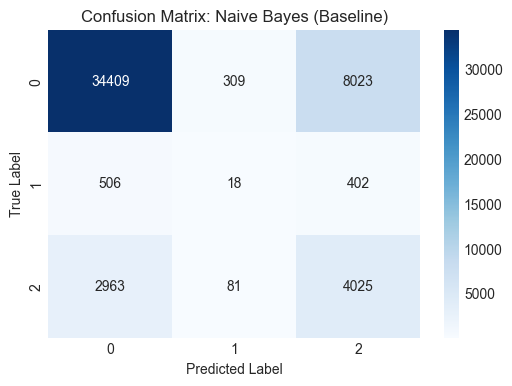

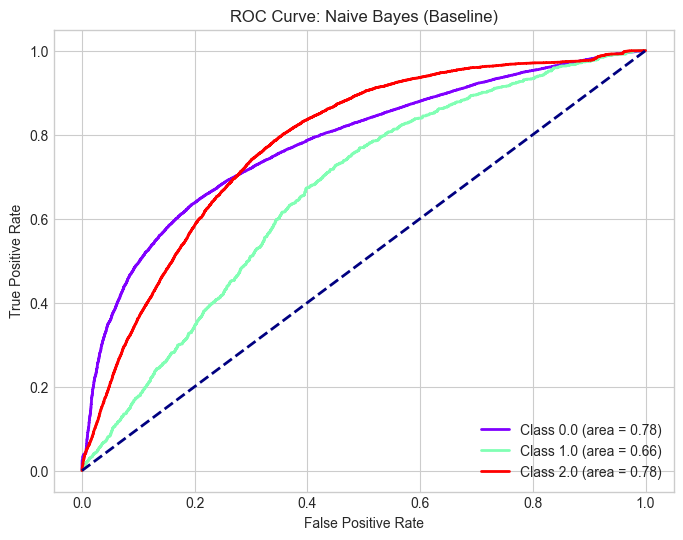

--- KNN [Baseline] ---
Acc: 0.8325 | Prec: 0.7874 | Rec: 0.8325 | F1: 0.8025 | AUC: 0.7200


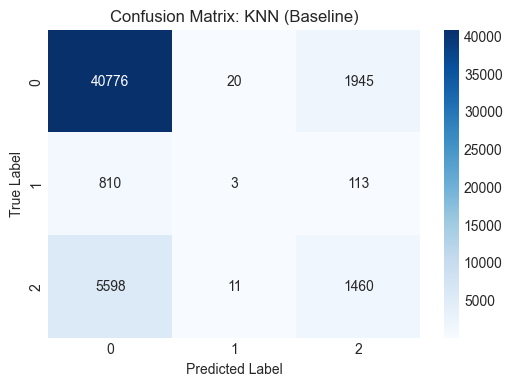

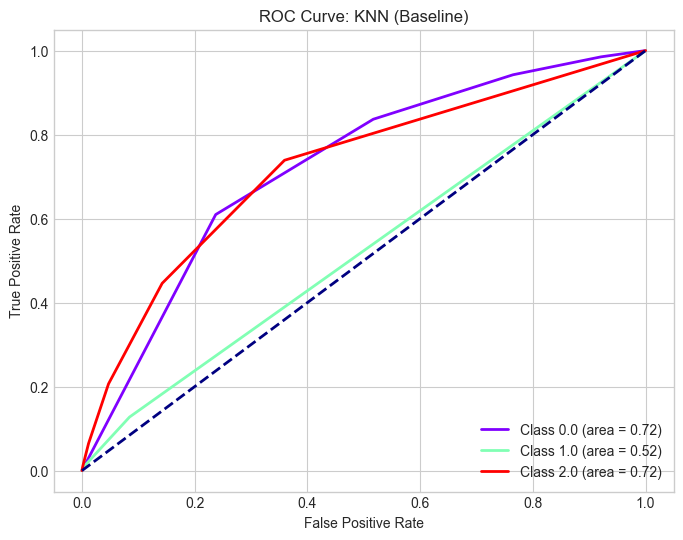

In [19]:
models = get_base_models(RANDOM_STATE)

print("Running Baseline...")
for name, model in models.items():
    # Test Eval
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    metrics = evaluate_model(y_test, y_pred, y_pred_proba, name, 'multi', 'Baseline')
    plot_metrics(y_test, y_pred, y_pred_proba, f'{name} (Baseline)', 'multi')
    full_results_multi.append(metrics)
    
    # CV
    # cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    # print(f"CV F1: {cv_scores.mean():.4f}")



## Phase 2: Hyperparameter Tuning (All Models)


Running Hyperparameter Tuning for ALL models...
Tuning Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params: {'C': 10, 'solver': 'lbfgs'}
--- Logistic Regression [Tuned] ---
Acc: 0.8455 | Prec: 0.7977 | Rec: 0.8455 | F1: 0.8069 | AUC: 0.8138


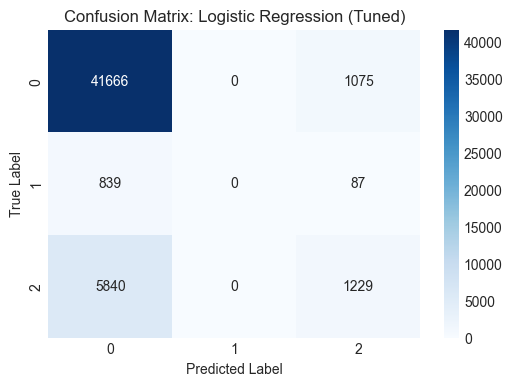

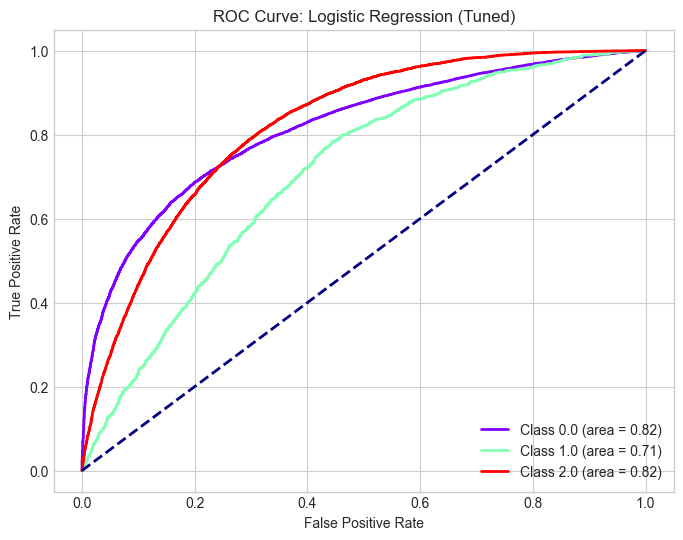

------------------------------
Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
--- Random Forest [Tuned] ---
Acc: 0.8474 | Prec: 0.8017 | Rec: 0.8474 | F1: 0.8103 | AUC: 0.8017


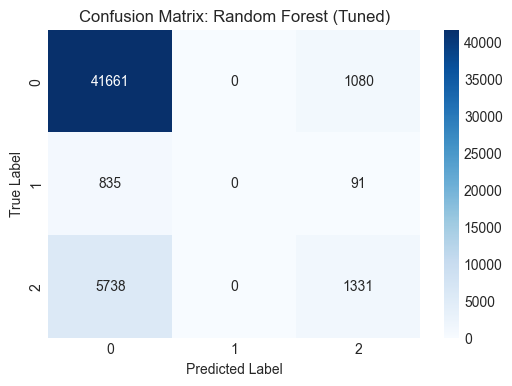

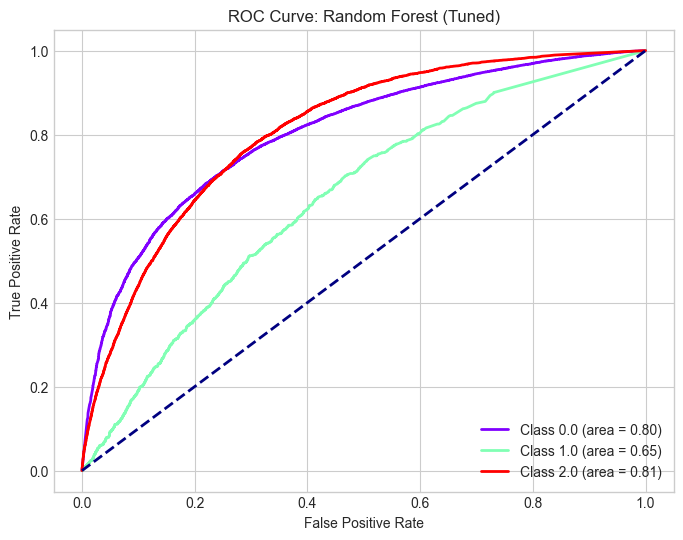

------------------------------
Tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
--- XGBoost [Tuned] ---
Acc: 0.8491 | Prec: 0.8046 | Rec: 0.8491 | F1: 0.8118 | AUC: 0.8225


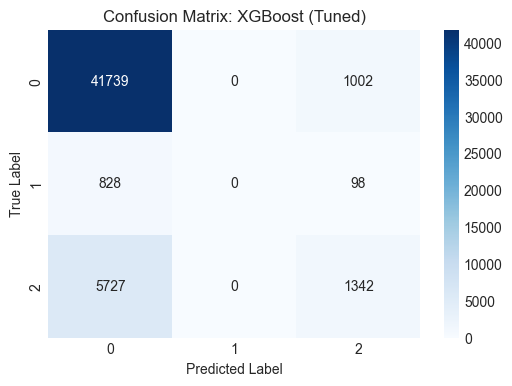

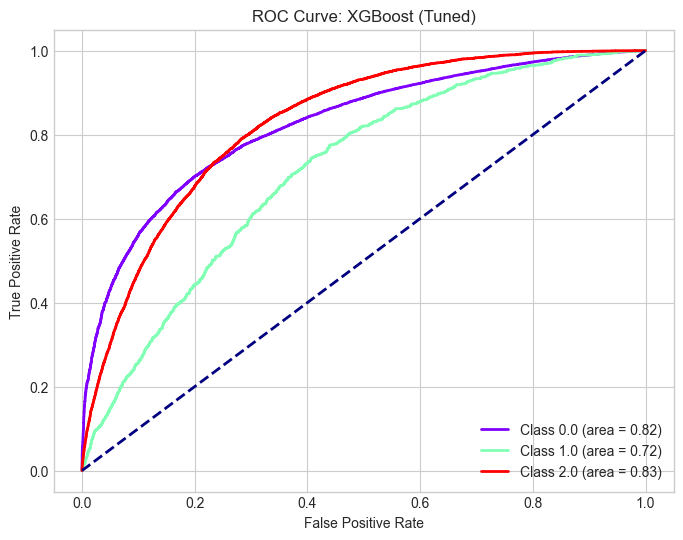

------------------------------
Tuning Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
--- Gradient Boosting [Tuned] ---
Acc: 0.8491 | Prec: 0.8048 | Rec: 0.8491 | F1: 0.8119 | AUC: 0.8229


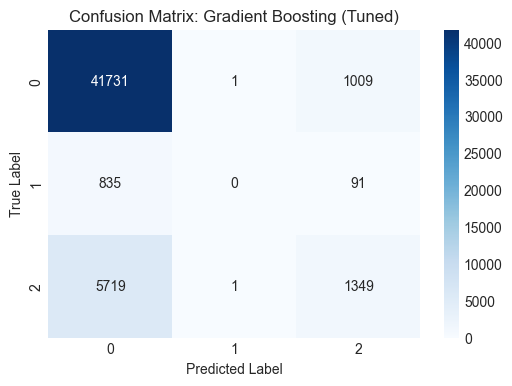

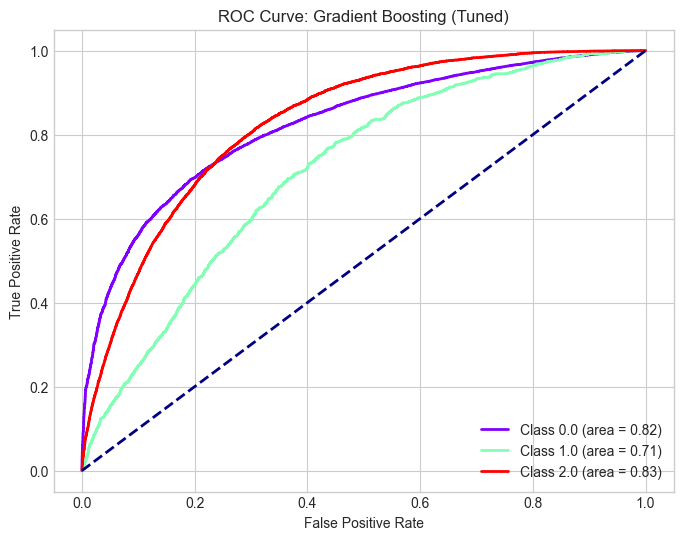

------------------------------
Tuning Decision Tree...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params: {'max_depth': 10, 'min_samples_split': 10}
--- Decision Tree [Tuned] ---
Acc: 0.8456 | Prec: 0.8050 | Rec: 0.8456 | F1: 0.8106 | AUC: 0.8032


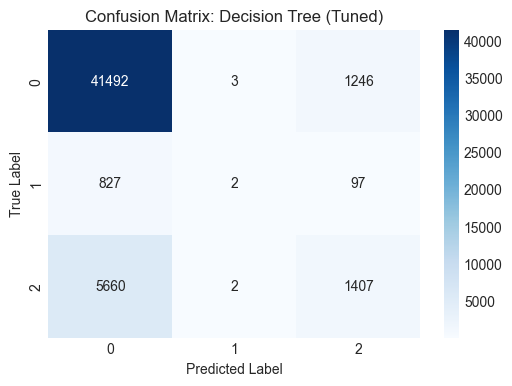

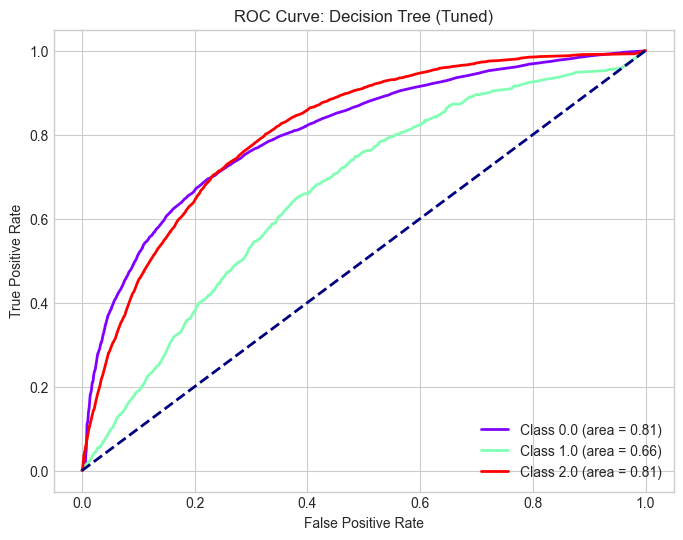

------------------------------
Tuning Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'var_smoothing': 1e-09}
--- Naive Bayes [Tuned] ---
Acc: 0.7579 | Prec: 0.8111 | Rec: 0.7579 | F1: 0.7771 | AUC: 0.7776


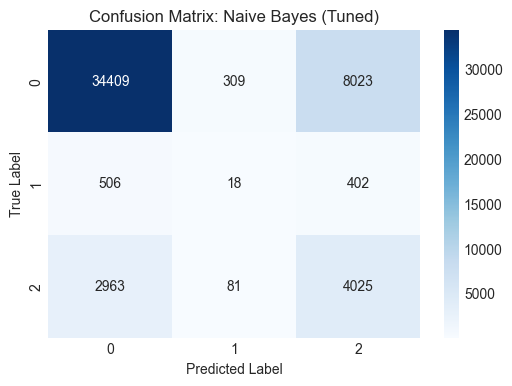

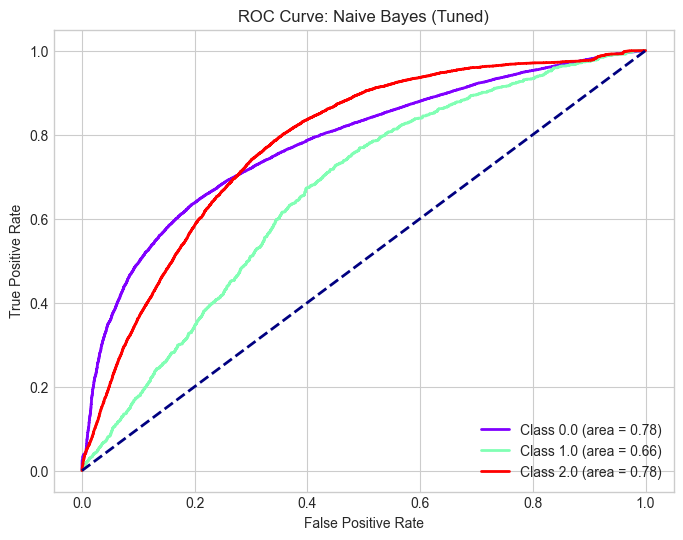

------------------------------
Tuning KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params: {'n_neighbors': 7, 'weights': 'uniform'}
--- KNN [Tuned] ---
Acc: 0.8364 | Prec: 0.7871 | Rec: 0.8364 | F1: 0.8028 | AUC: 0.7418


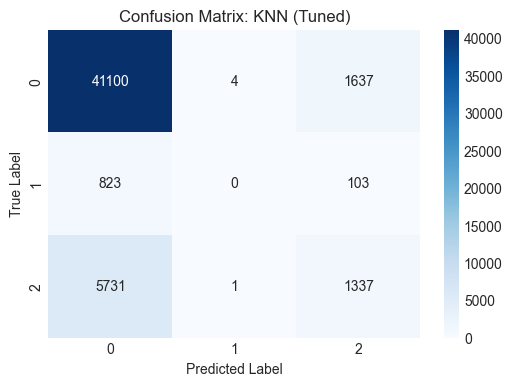

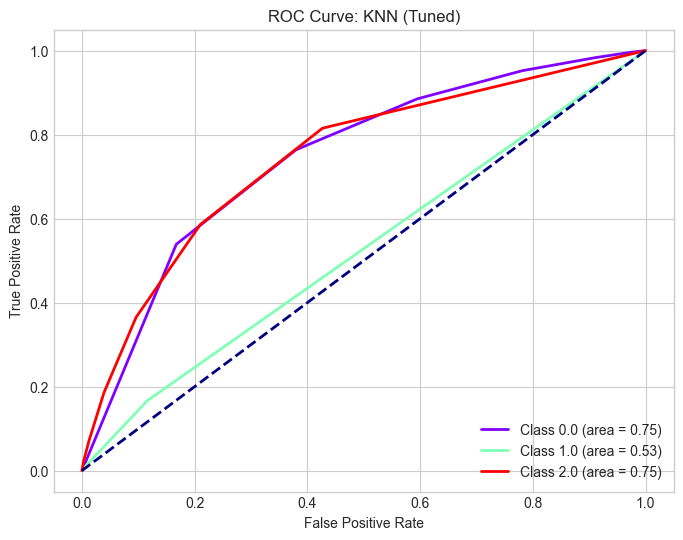

------------------------------


In [20]:
tuned_models_multi = {}
param_grids = get_param_grids(RANDOM_STATE)

print("Running Hyperparameter Tuning for ALL models...")
for name, model in models.items():
    print(f"Tuning {name}...")
    
    if name in param_grids:
        grid = param_grids[name]
        # Use RandomizedSearchCV if grid is large, or GridSearchCV for smaller. Using Grid for now.
        search = GridSearchCV(model, grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best Params: {search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)
    
    tuned_models_multi[name] = best_model
    
    # Evaluate
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    metrics = evaluate_model(y_test, y_pred, y_pred_proba, name, 'multi', 'Tuned')
    plot_metrics(y_test, y_pred, y_pred_proba, f'{name} (Tuned)', 'multi')
    full_results_multi.append(metrics)
    print("-" * 30)



## Phase 3: SMOTE (All Models)


Applying SMOTE...
Retraining ALL tuned models on SMOTE data...
Retraining Logistic Regression (SMOTE)...
--- Logistic Regression [SMOTE] ---
Acc: 0.6418 | Prec: 0.8506 | Rec: 0.6418 | F1: 0.7184 | AUC: 0.8110


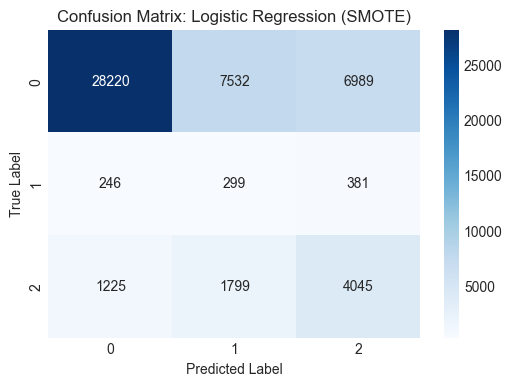

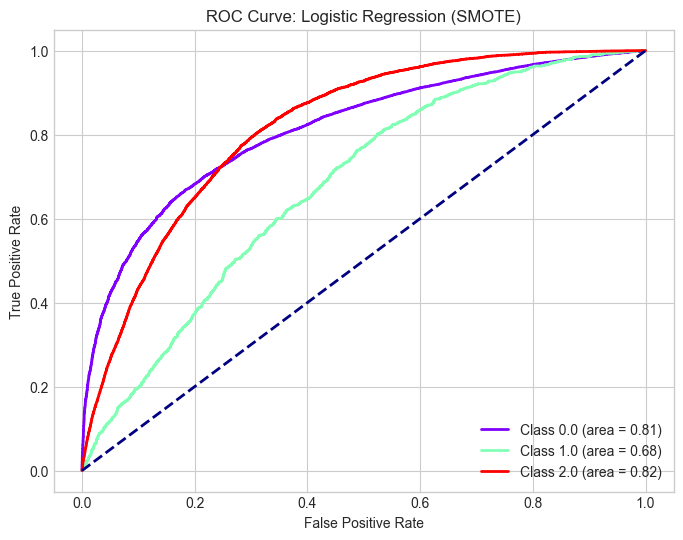

Retraining Random Forest (SMOTE)...
--- Random Forest [SMOTE] ---
Acc: 0.8332 | Prec: 0.8069 | Rec: 0.8332 | F1: 0.8187 | AUC: 0.7990


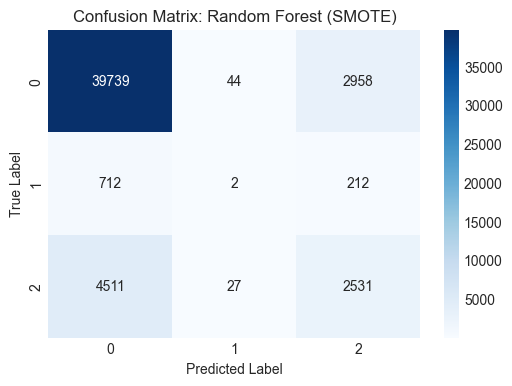

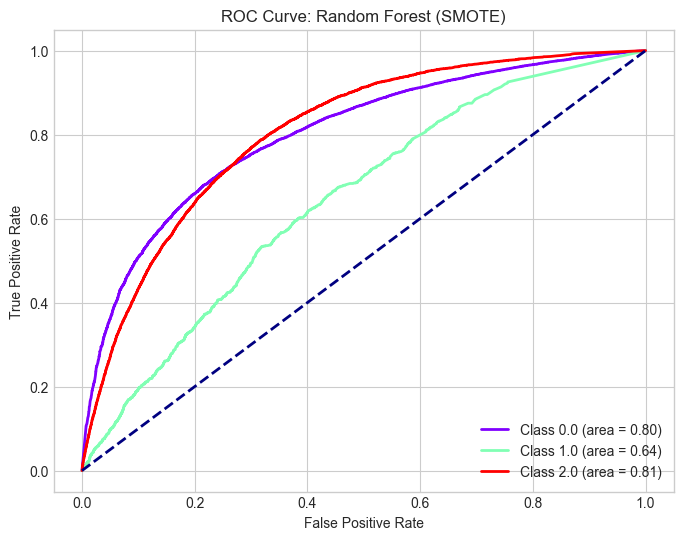

Retraining XGBoost (SMOTE)...
--- XGBoost [SMOTE] ---
Acc: 0.8303 | Prec: 0.8129 | Rec: 0.8303 | F1: 0.8215 | AUC: 0.8122


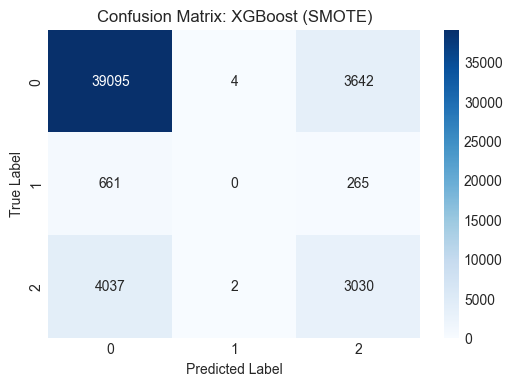

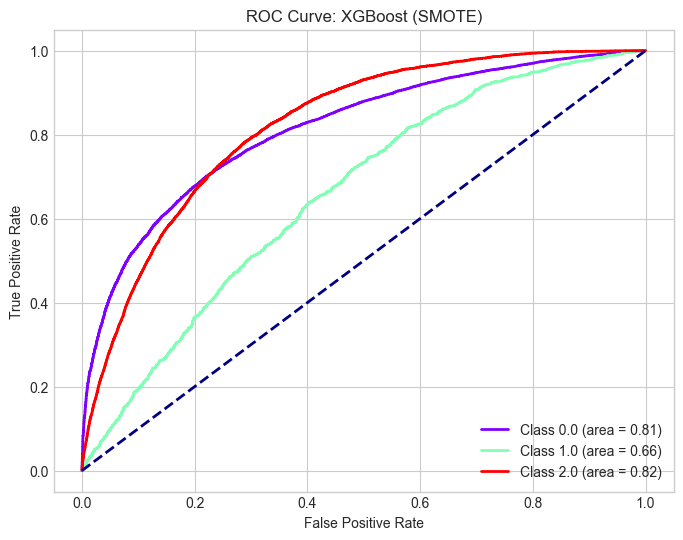

Retraining Gradient Boosting (SMOTE)...
--- Gradient Boosting [SMOTE] ---
Acc: 0.8373 | Prec: 0.8098 | Rec: 0.8373 | F1: 0.8224 | AUC: 0.8124


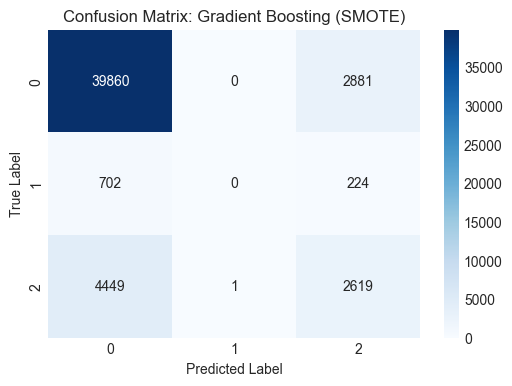

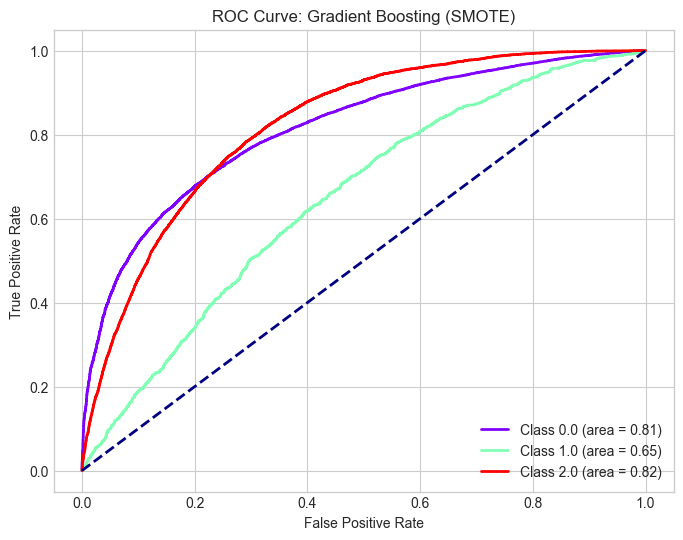

Retraining Decision Tree (SMOTE)...
--- Decision Tree [SMOTE] ---
Acc: 0.8006 | Prec: 0.8131 | Rec: 0.8006 | F1: 0.8051 | AUC: 0.7859


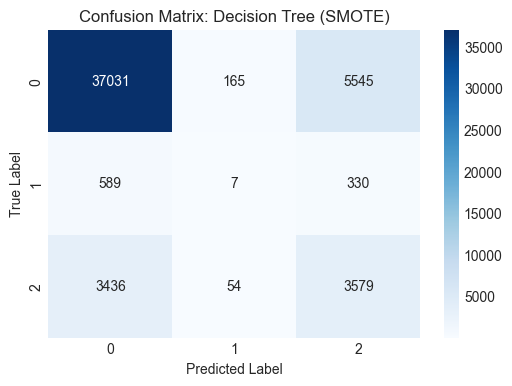

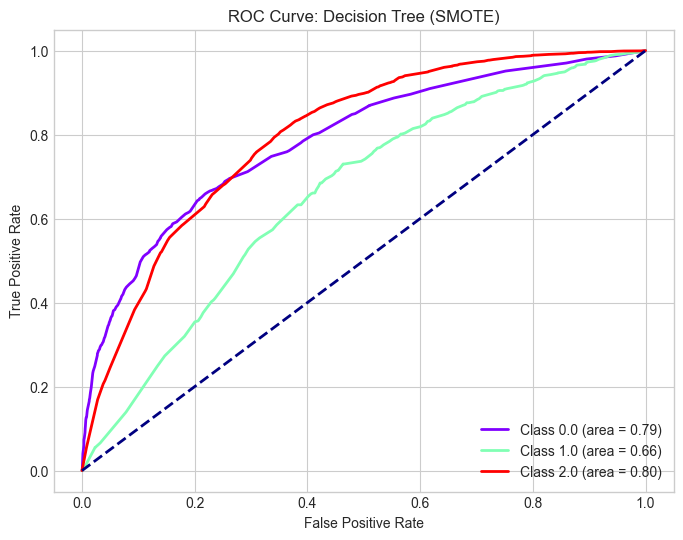

Retraining Naive Bayes (SMOTE)...
--- Naive Bayes [SMOTE] ---
Acc: 0.6695 | Prec: 0.8324 | Rec: 0.6695 | F1: 0.7273 | AUC: 0.7796


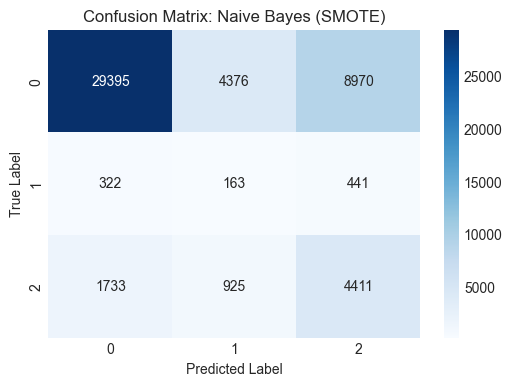

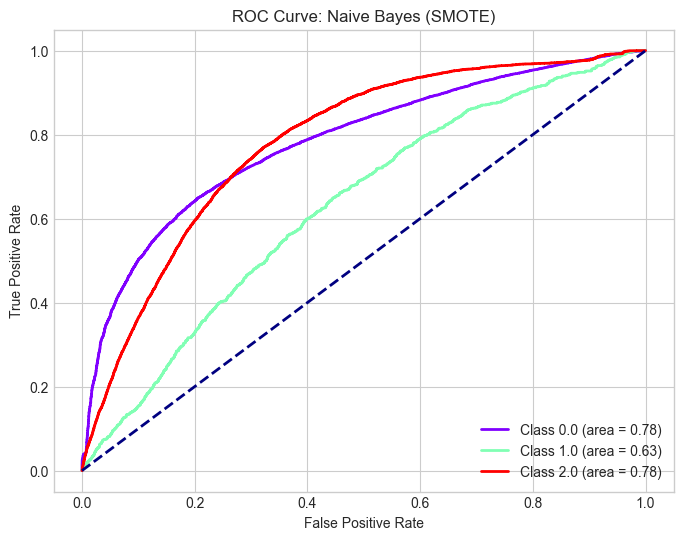

Retraining KNN (SMOTE)...
--- KNN [SMOTE] ---
Acc: 0.6459 | Prec: 0.8164 | Rec: 0.6459 | F1: 0.7054 | AUC: 0.7302


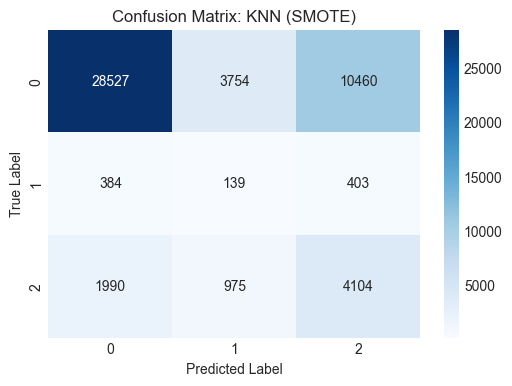

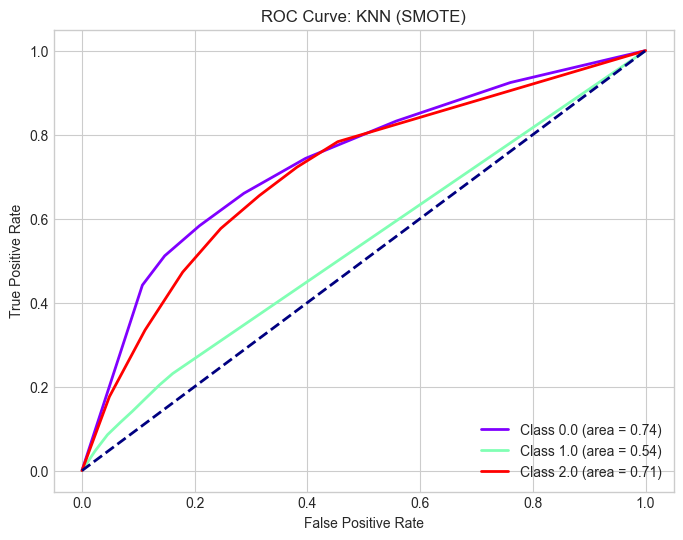

In [21]:
print("Applying SMOTE...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

tuned_models_smote_multi = {}

print("Retraining ALL tuned models on SMOTE data...")
for name, model in tuned_models_multi.items():
    print(f"Retraining {name} (SMOTE)...")
    from sklearn.base import clone
    model_smote = clone(model)
    model_smote.fit(X_train_smote, y_train_smote)
    tuned_models_smote_multi[name] = model_smote
    
    y_pred = model_smote.predict(X_test)
    y_pred_proba = model_smote.predict_proba(X_test)
    metrics = evaluate_model(y_test, y_pred, y_pred_proba, name, 'multi', 'SMOTE')
    plot_metrics(y_test, y_pred, y_pred_proba, f'{name} (SMOTE)', 'multi')
    full_results_multi.append(metrics)



In [22]:
# Summary DataFrame
df_results_multi = pd.DataFrame(full_results_multi)
print("Full Multi-class Results:")
display(df_results_multi.sort_values(by=['Model', 'F1_Score'], ascending=False))



Full Multi-class Results:


Model     Phase  Accuracy  Precision    Recall  F1_Score  \
16              XGBoost     SMOTE  0.830278   0.812904  0.830278  0.821473   
2               XGBoost  Baseline  0.848924   0.804389  0.848924  0.811935   
9               XGBoost     Tuned  0.849121   0.804645  0.849121  0.811807   
15        Random Forest     SMOTE  0.833176   0.806916  0.833176  0.818718   
8         Random Forest     Tuned  0.847367   0.801740  0.847367  0.810305   
1         Random Forest  Baseline  0.842893   0.797195  0.842893  0.808799   
5           Naive Bayes  Baseline  0.757884   0.811117  0.757884  0.777061   
12          Naive Bayes     Tuned  0.757884   0.811117  0.757884  0.777061   
19          Naive Bayes     SMOTE  0.669525   0.832383  0.669525  0.727313   
0   Logistic Regression  Baseline  0.845455   0.797654  0.845455  0.806908   
7   Logistic Regression     Tuned  0.845455   0.797654  0.845455  0.806908   
14  Logistic Regression     SMOTE  0.641832   0.850622  0.641832  0.718440   
13                  KNN     Tuned  0.836428   0.787100  0.836428  0.802768   
6                   KNN  Baseline  0.832525   0.787445  0.832525  0.802524   
20                  KNN     SMOTE  0.645892   0.816425  0.645892  0.705436   
17    Gradient Boosting     SMOTE  0.837256   0.809764  0.837256  0.822360   
10    Gradient Boosting     Tuned  0.849101   0.804821  0.849101  0.811912   
3     Gradient Boosting  Baseline  0.848668   0.804023  0.848668  0.811648   
11        Decision Tree     Tuned  0.845573   0.805021  0.845573  0.810592   
18        Decision Tree     SMOTE  0.800556   0.813143  0.800556  0.805134   
4         Decision Tree  Baseline  0.766556   0.779656  0.766556  0.772893   

     ROC_AUC  
16  0.812220  
2   0.820206  
9   0.822522  
15  0.798981  
8   0.801686  
1   0.790962  
5   0.777603  
12  0.777603  
19  0.779639  
0   0.813832  
7   0.813832  
14  0.811032  
13  0.741835  
6   0.719987  
20  0.730227  
17  0.812429  
10  0.822854  
3   0.822450  
11  0.803158  
18  0.785856  
4   0.601928

# ⚖️ PART B: BINARY CLASSIFICATION


In [23]:
full_results_bi = []
y_binary = y.replace({2: 1})
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(
    X_scaled, y_binary, test_size=0.2, stratify=y_binary, random_state=RANDOM_STATE
)



## Phase 1: Baseline (Binary, All Models)


Running Baseline Binary...
--- Logistic Regression [Baseline] ---
Acc: 0.8481 | Prec: 0.5520 | Rec: 0.1911 | F1: 0.2839 | AUC: 0.8172


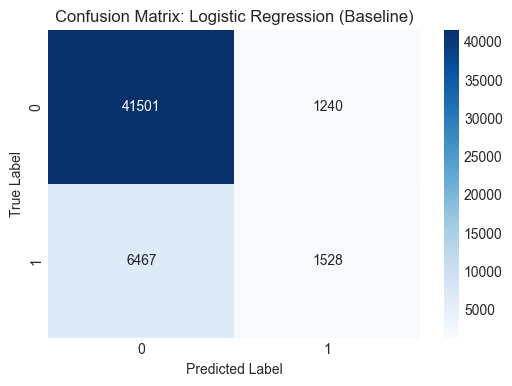

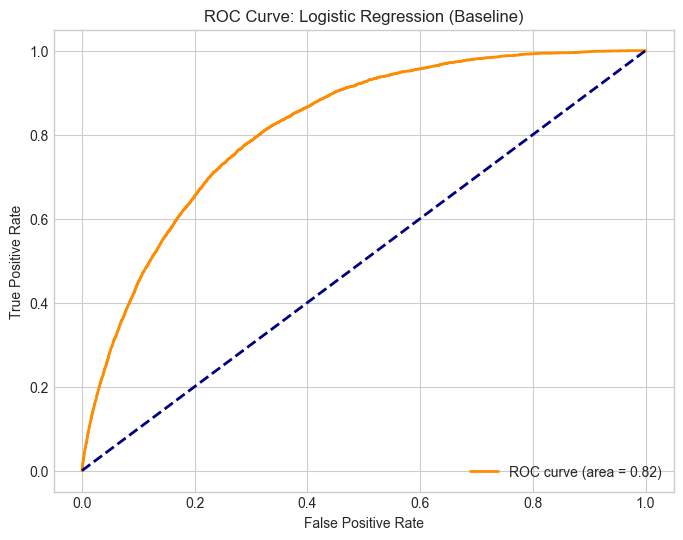

--- Random Forest [Baseline] ---
Acc: 0.8448 | Prec: 0.5184 | Rec: 0.2154 | F1: 0.3043 | AUC: 0.7920


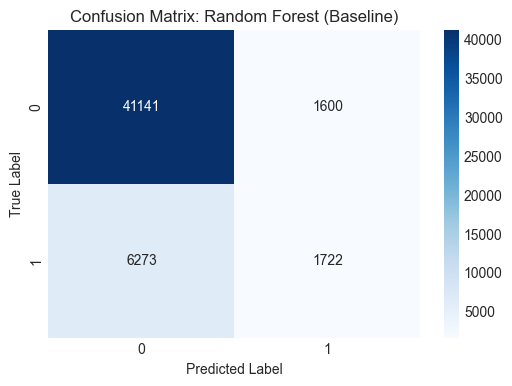

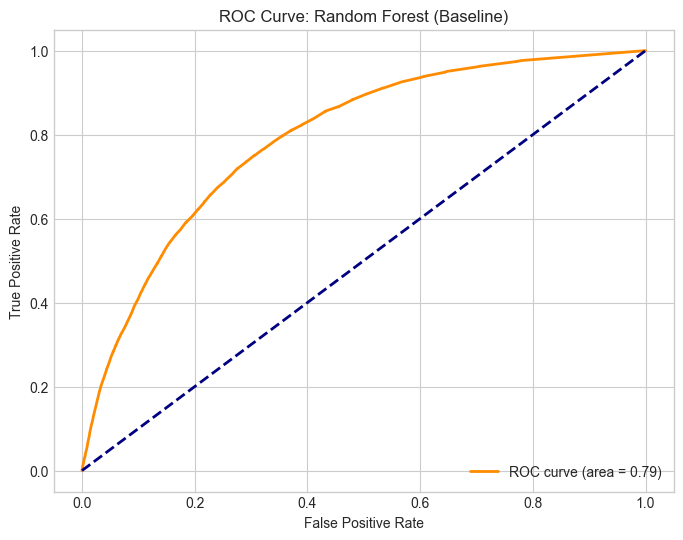

--- XGBoost [Baseline] ---
Acc: 0.8505 | Prec: 0.5706 | Rec: 0.2063 | F1: 0.3030 | AUC: 0.8194


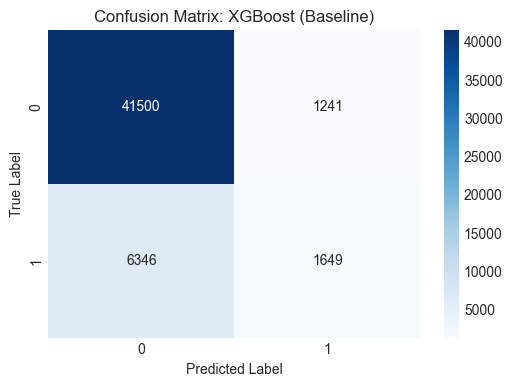

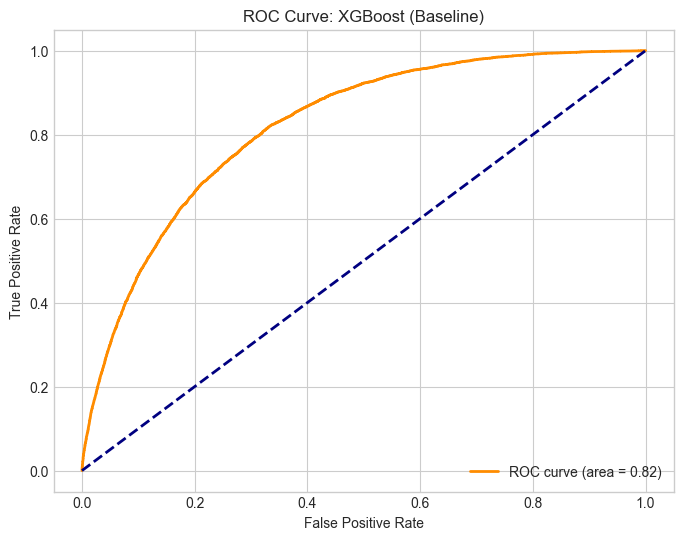

--- Gradient Boosting [Baseline] ---
Acc: 0.8512 | Prec: 0.5748 | Rec: 0.2134 | F1: 0.3112 | AUC: 0.8244


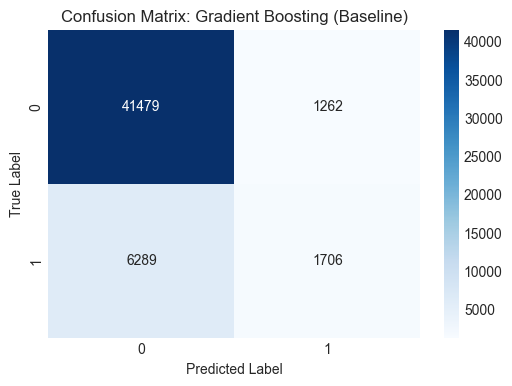

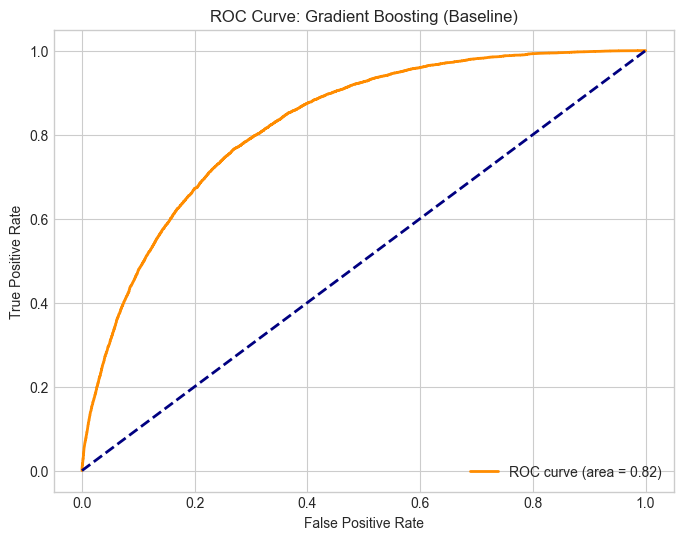

--- Decision Tree [Baseline] ---
Acc: 0.7785 | Prec: 0.3126 | Rec: 0.3381 | F1: 0.3248 | AUC: 0.5985


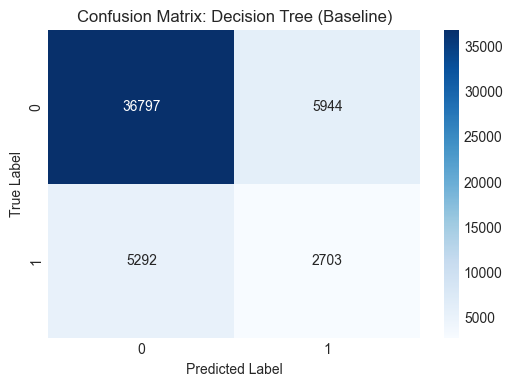

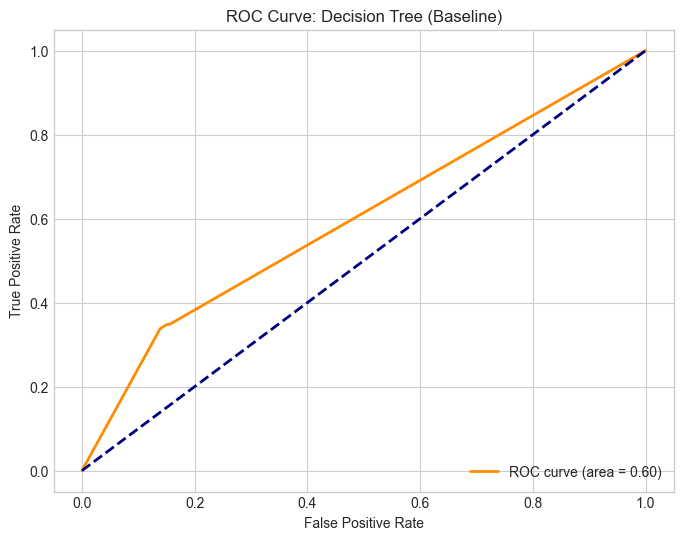

--- Naive Bayes [Baseline] ---
Acc: 0.7672 | Prec: 0.3523 | Rec: 0.5691 | F1: 0.4352 | AUC: 0.7808


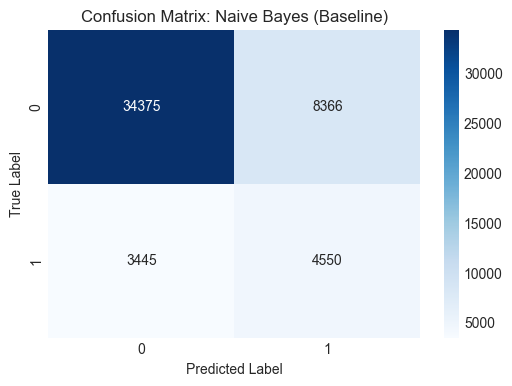

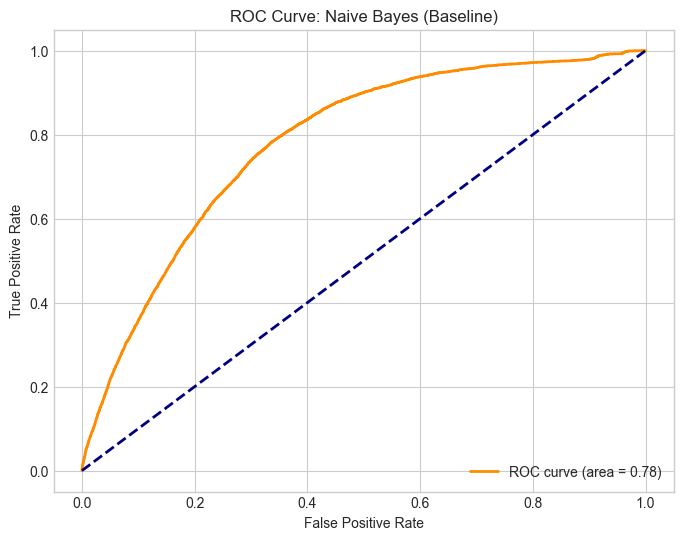

--- KNN [Baseline] ---
Acc: 0.8306 | Prec: 0.4322 | Rec: 0.2385 | F1: 0.3074 | AUC: 0.7258


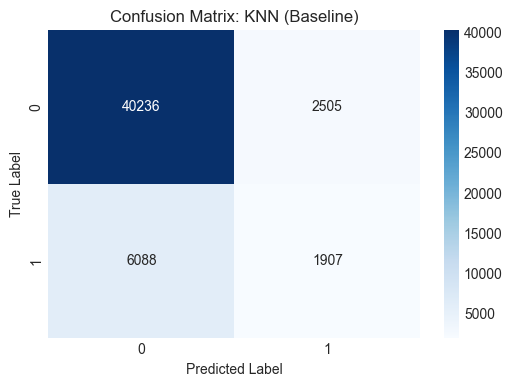

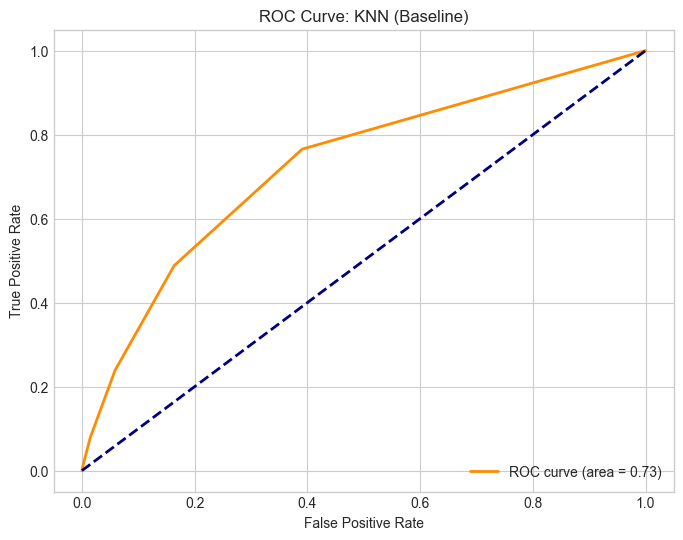

In [24]:
models_bi = get_base_models(RANDOM_STATE)

print("Running Baseline Binary...")
for name, model in models_bi.items():
    model.fit(X_train_bi, y_train_bi)
    y_pred = model.predict(X_test_bi)
    y_pred_proba = model.predict_proba(X_test_bi)
    metrics = evaluate_model(y_test_bi, y_pred, y_pred_proba, name, 'binary', 'Baseline')
    plot_metrics(y_test_bi, y_pred, y_pred_proba, f'{name} (Baseline)', 'binary')
    full_results_bi.append(metrics)



## Phase 2: Tuning (Binary, All Models)


Tuning Binary Models...
Tuning Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--- Logistic Regression [Tuned] ---
Acc: 0.8481 | Prec: 0.5520 | Rec: 0.1911 | F1: 0.2839 | AUC: 0.8172


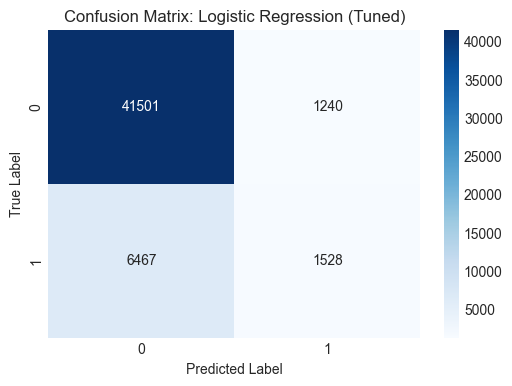

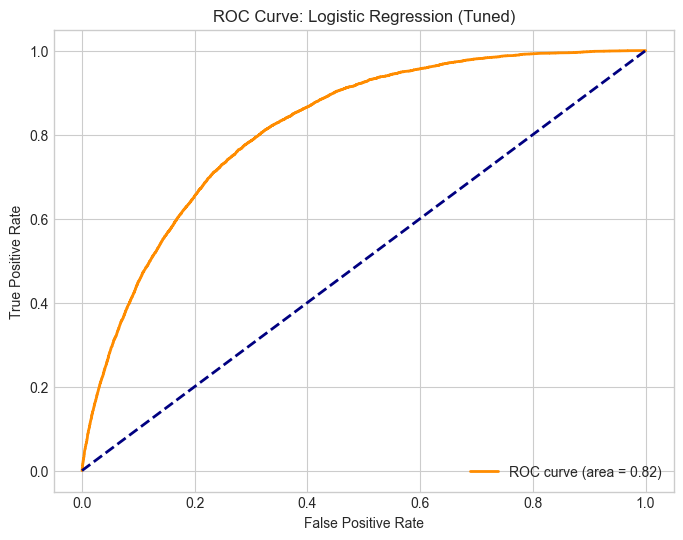

Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
--- Random Forest [Tuned] ---
Acc: 0.8449 | Prec: 0.5191 | Rec: 0.2155 | F1: 0.3046 | AUC: 0.7944


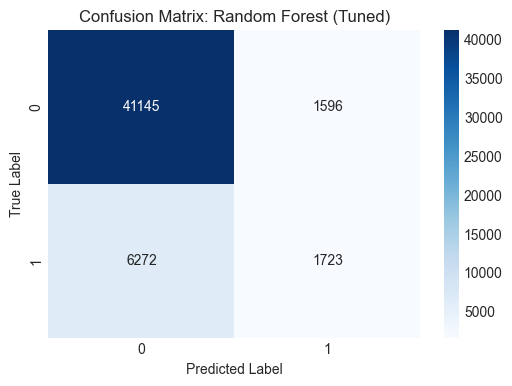

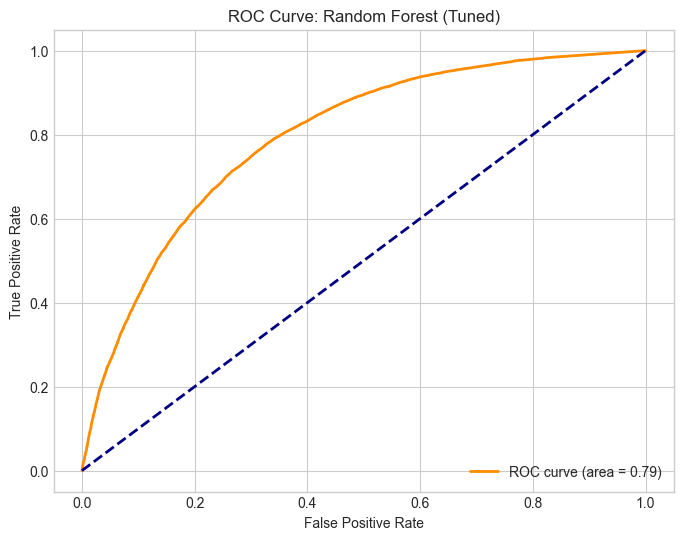

Tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
--- XGBoost [Tuned] ---
Acc: 0.8517 | Prec: 0.5843 | Rec: 0.2051 | F1: 0.3036 | AUC: 0.8231


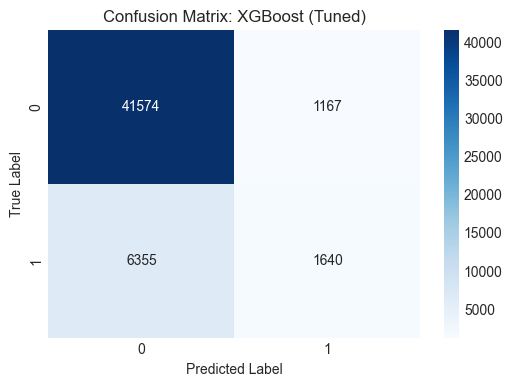

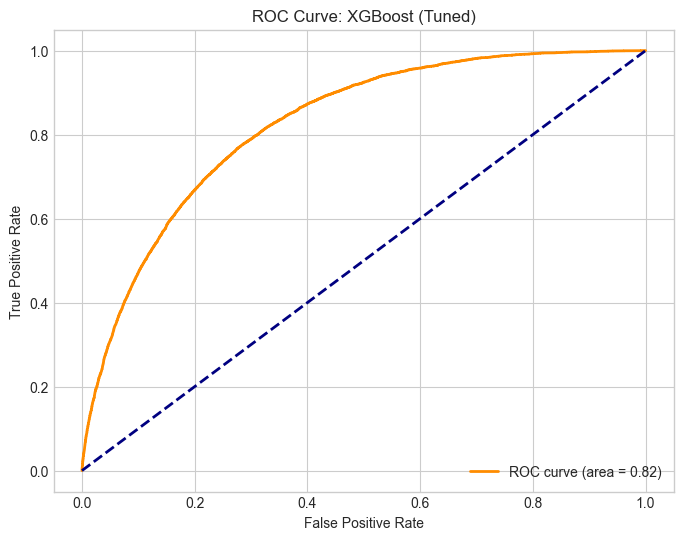

Tuning Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
--- Gradient Boosting [Tuned] ---
Acc: 0.8520 | Prec: 0.5800 | Rec: 0.2194 | F1: 0.3184 | AUC: 0.8250


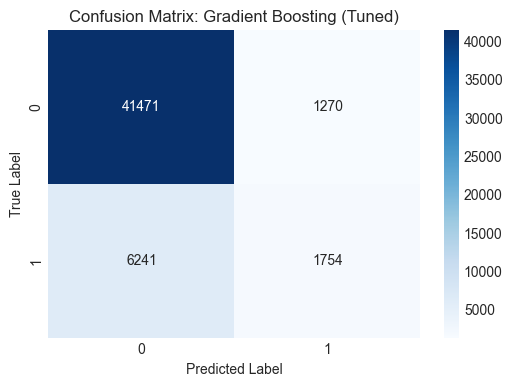

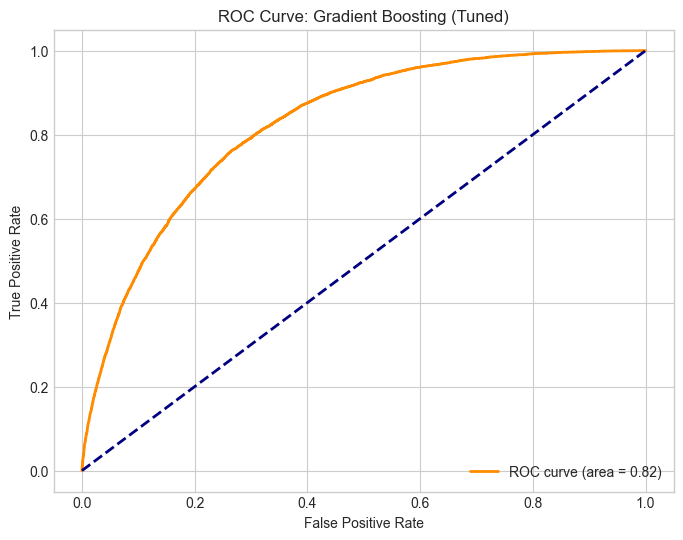

Tuning Decision Tree...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--- Decision Tree [Tuned] ---
Acc: 0.7785 | Prec: 0.3126 | Rec: 0.3381 | F1: 0.3248 | AUC: 0.5985


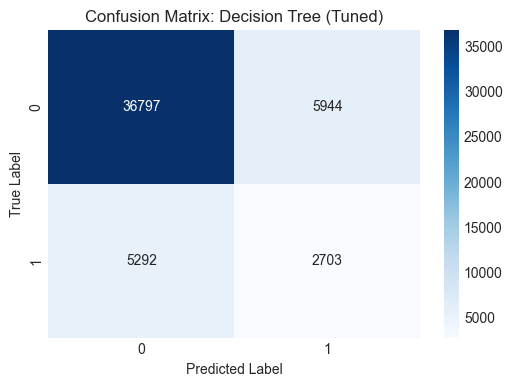

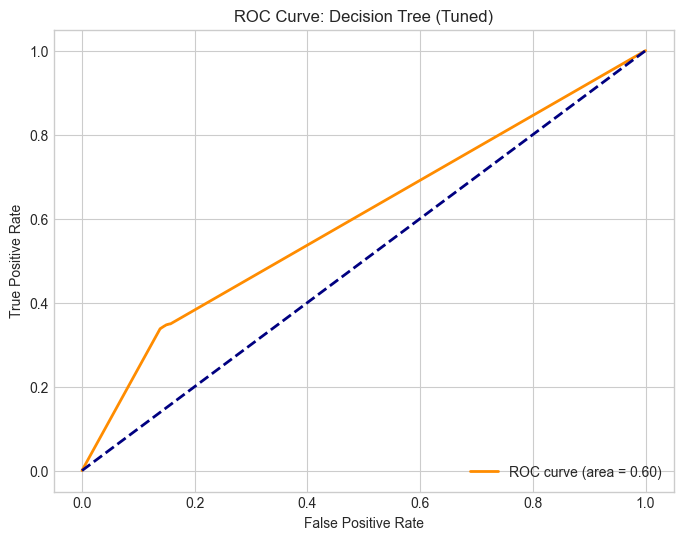

Tuning Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
--- Naive Bayes [Tuned] ---
Acc: 0.7672 | Prec: 0.3523 | Rec: 0.5691 | F1: 0.4352 | AUC: 0.7808


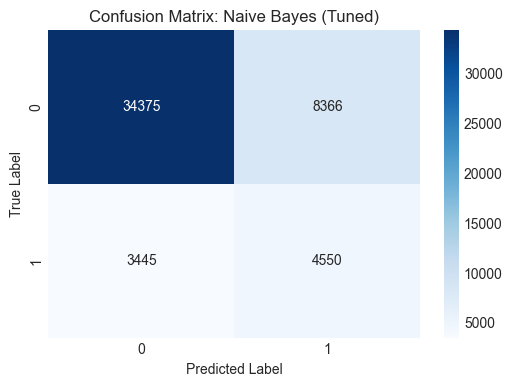

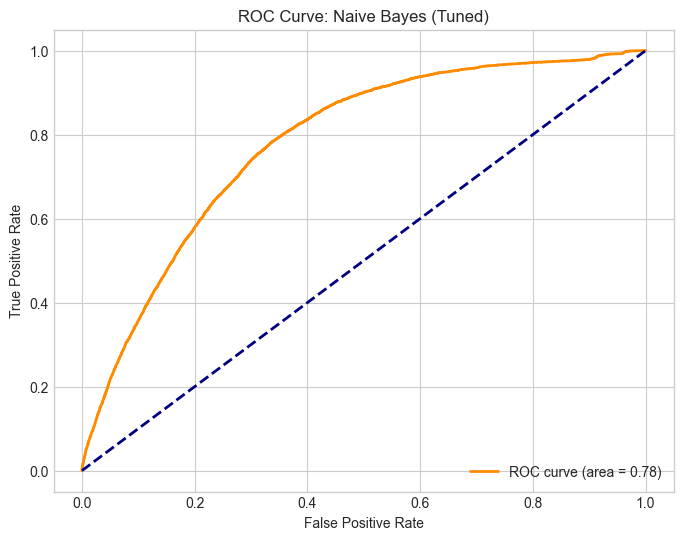

Tuning KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--- KNN [Tuned] ---
Acc: 0.8144 | Prec: 0.3779 | Rec: 0.2750 | F1: 0.3184 | AUC: 0.6857


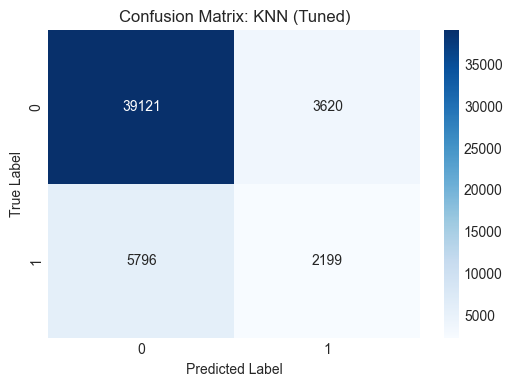

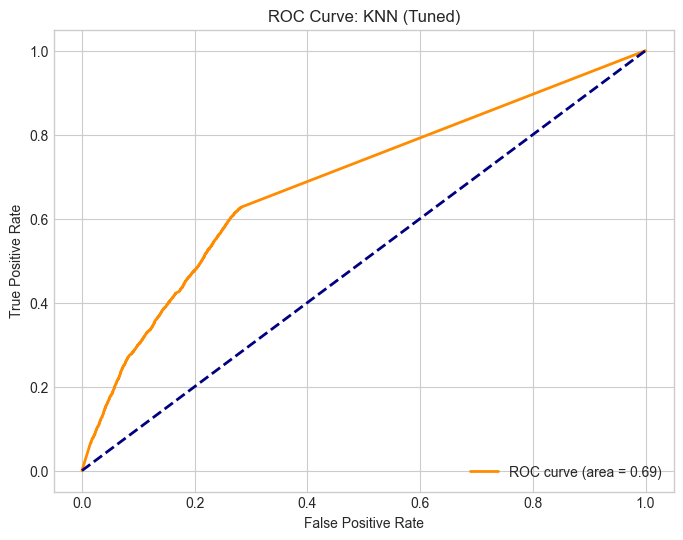

In [25]:
tuned_models_bi = {}
print("Tuning Binary Models...")

for name, model in models_bi.items():
    print(f"Tuning {name}...")
    if name in param_grids:
        grid = param_grids[name]
        search = GridSearchCV(model, grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
        search.fit(X_train_bi, y_train_bi)
        best_model = search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_bi, y_train_bi)
        
    tuned_models_bi[name] = best_model
    
    y_pred = best_model.predict(X_test_bi)
    y_pred_proba = best_model.predict_proba(X_test_bi)
    metrics = evaluate_model(y_test_bi, y_pred, y_pred_proba, name, 'binary', 'Tuned')
    plot_metrics(y_test_bi, y_pred, y_pred_proba, f'{name} (Tuned)', 'binary')
    full_results_bi.append(metrics)



## Phase 3: SMOTE (Binary, All Models)


Applying SMOTE Binary...
Retraining All Binary Models on SMOTE...
Retraining Logistic Regression...
--- Logistic Regression [SMOTE] ---
Acc: 0.7309 | Prec: 0.3409 | Rec: 0.7578 | F1: 0.4702 | AUC: 0.8165


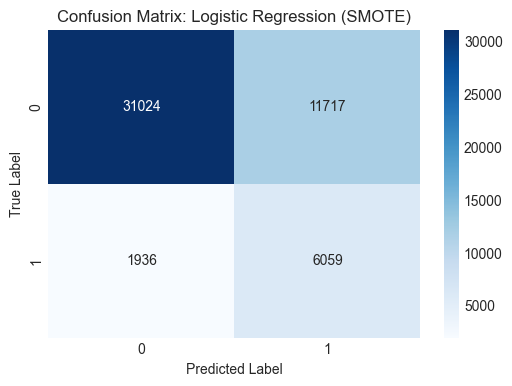

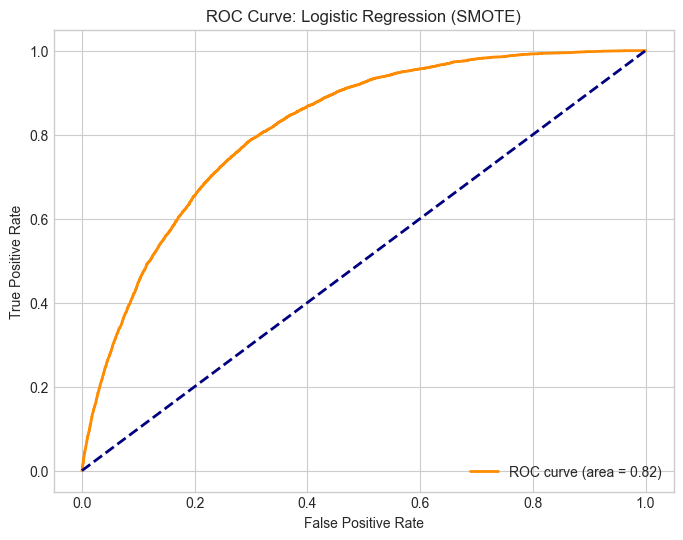

Retraining Random Forest...
--- Random Forest [SMOTE] ---
Acc: 0.8357 | Prec: 0.4678 | Rec: 0.3112 | F1: 0.3738 | AUC: 0.7940


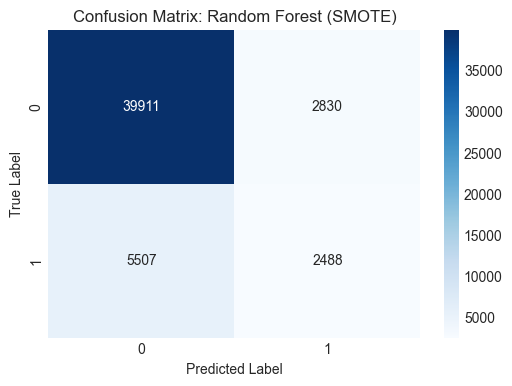

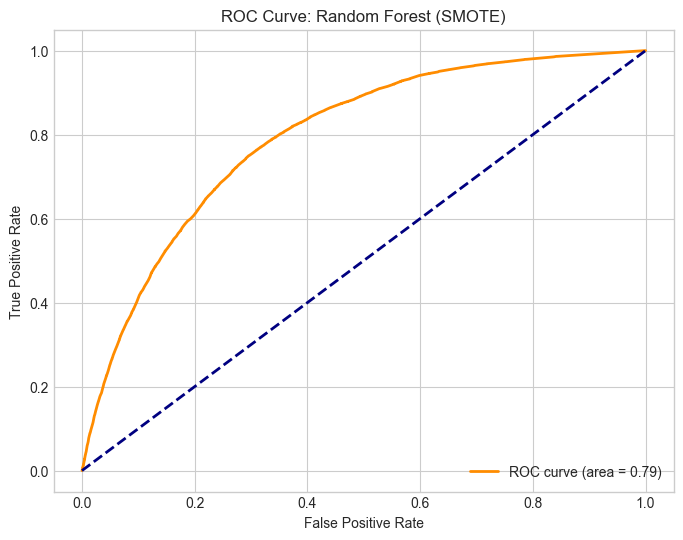

Retraining XGBoost...
--- XGBoost [SMOTE] ---
Acc: 0.8509 | Prec: 0.5607 | Rec: 0.2478 | F1: 0.3437 | AUC: 0.8218


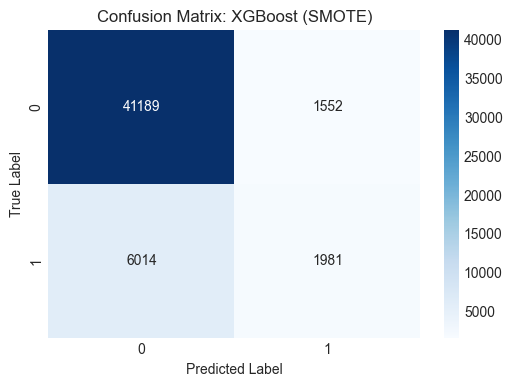

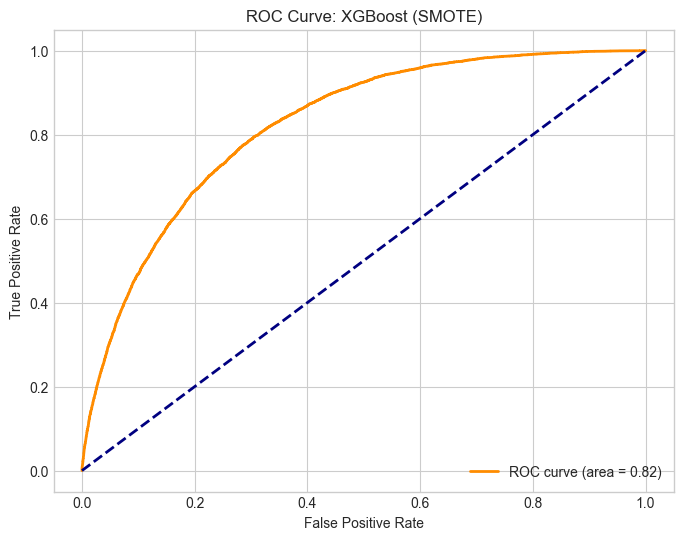

Retraining Gradient Boosting...
--- Gradient Boosting [SMOTE] ---
Acc: 0.8449 | Prec: 0.5118 | Rec: 0.3460 | F1: 0.4129 | AUC: 0.8189


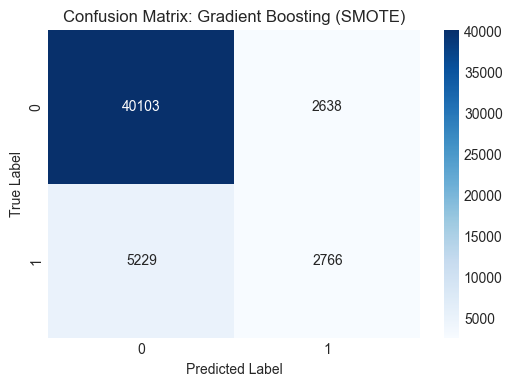

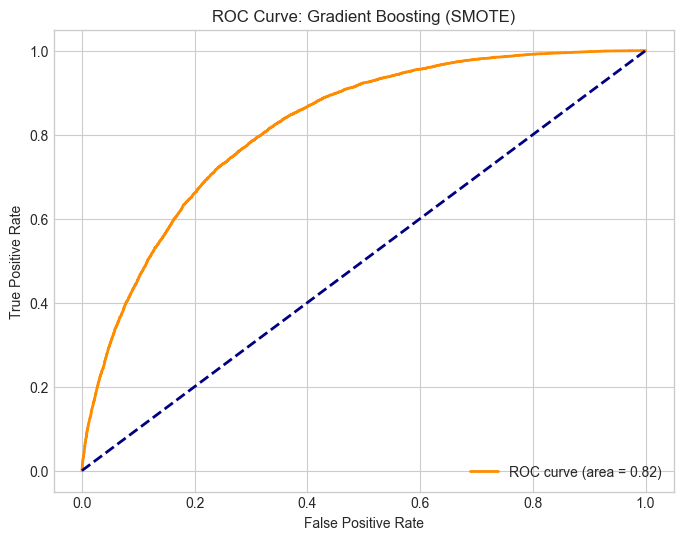

Retraining Decision Tree...
--- Decision Tree [SMOTE] ---
Acc: 0.7771 | Prec: 0.3139 | Rec: 0.3495 | F1: 0.3307 | AUC: 0.6022


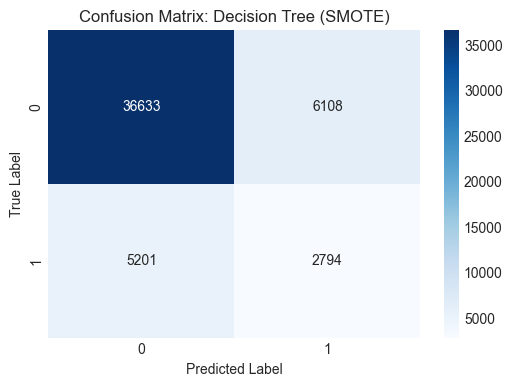

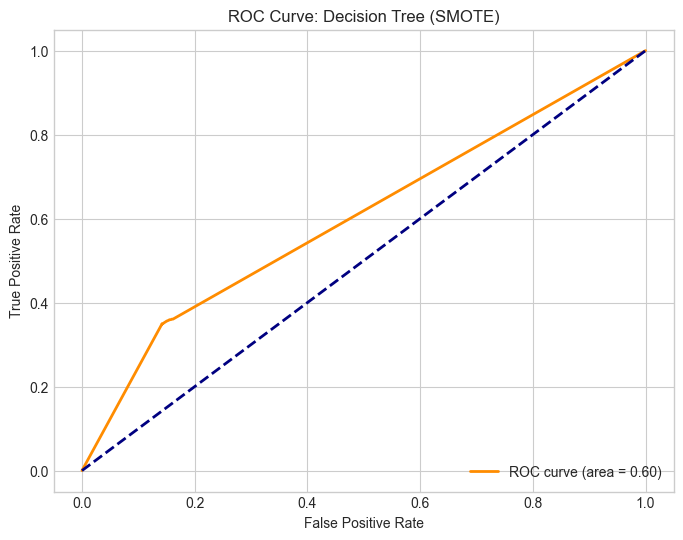

Retraining Naive Bayes...
--- Naive Bayes [SMOTE] ---
Acc: 0.7250 | Prec: 0.3268 | Rec: 0.7028 | F1: 0.4461 | AUC: 0.7838


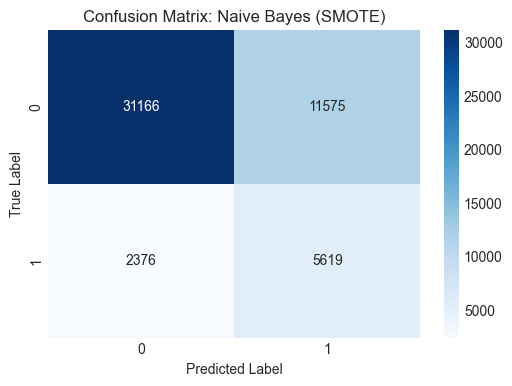

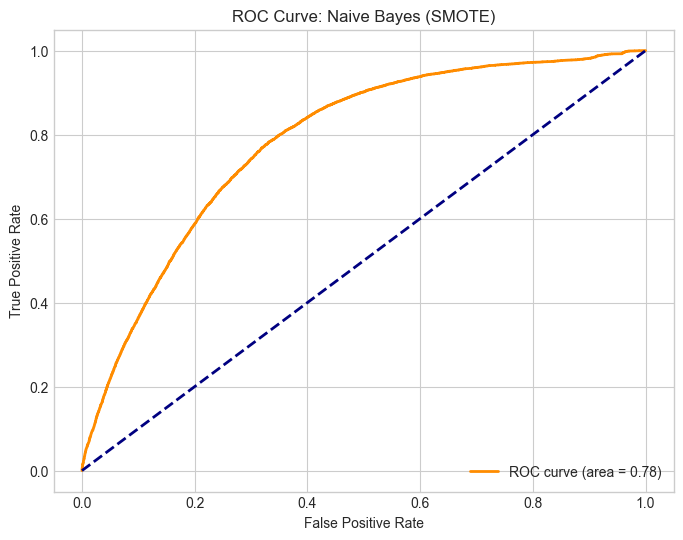

Retraining KNN...
--- KNN [SMOTE] ---
Acc: 0.7380 | Prec: 0.3087 | Rec: 0.5345 | F1: 0.3914 | AUC: 0.6972


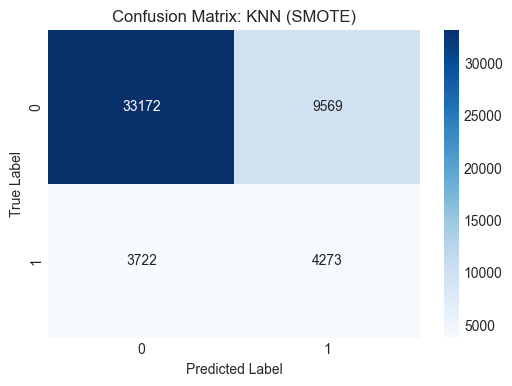

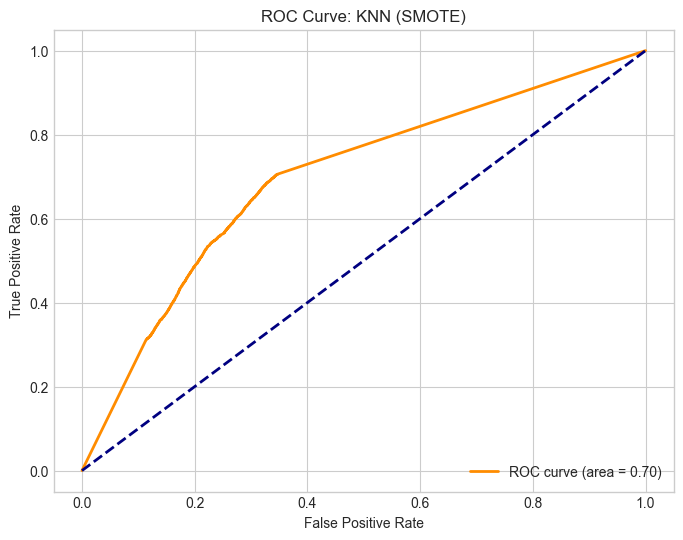

In [26]:
print("Applying SMOTE Binary...")
smote_bi = SMOTE(random_state=RANDOM_STATE)
X_train_smote_bi, y_train_smote_bi = smote_bi.fit_resample(X_train_bi, y_train_bi)

tuned_models_smote_bi = {}
print("Retraining All Binary Models on SMOTE...")

for name, model in tuned_models_bi.items():
    print(f"Retraining {name}...")
    from sklearn.base import clone
    model_smote = clone(model)
    model_smote.fit(X_train_smote_bi, y_train_smote_bi)
    tuned_models_smote_bi[name] = model_smote
    
    y_pred = model_smote.predict(X_test_bi)
    y_pred_proba = model_smote.predict_proba(X_test_bi)
    metrics = evaluate_model(y_test_bi, y_pred, y_pred_proba, name, 'binary', 'SMOTE')
    plot_metrics(y_test_bi, y_pred, y_pred_proba, f'{name} (SMOTE)', 'binary')
    full_results_bi.append(metrics)



In [27]:
# Summary DataFrame Binary
df_results_bi = pd.DataFrame(full_results_bi)
print("Full Binary Results:")
display(df_results_bi.sort_values(by=['Model', 'F1_Score'], ascending=False))



Full Binary Results:


Model     Phase  Accuracy  Precision    Recall  F1_Score  \
16              XGBoost     SMOTE  0.850875   0.560713  0.247780  0.343685   
9               XGBoost     Tuned  0.851742   0.584254  0.205128  0.303647   
2               XGBoost  Baseline  0.850461   0.570588  0.206254  0.302986   
15        Random Forest     SMOTE  0.835679   0.467845  0.311194  0.373770   
8         Random Forest     Tuned  0.844923   0.519132  0.215510  0.304578   
1         Random Forest  Baseline  0.844824   0.518362  0.215385  0.304321   
19          Naive Bayes     SMOTE  0.725028   0.326800  0.702814  0.446147   
5           Naive Bayes  Baseline  0.767207   0.352276  0.569106  0.435178   
12          Naive Bayes     Tuned  0.767207   0.352276  0.569106  0.435178   
14  Logistic Regression     SMOTE  0.730901   0.340853  0.757849  0.470218   
0   Logistic Regression  Baseline  0.848096   0.552023  0.191119  0.283936   
7   Logistic Regression     Tuned  0.848096   0.552023  0.191119  0.283936   
20                  KNN     SMOTE  0.738036   0.308698  0.534459  0.391354   
13                  KNN     Tuned  0.814412   0.377900  0.275047  0.318373   
6                   KNN  Baseline  0.830633   0.432230  0.238524  0.307407   
17    Gradient Boosting     SMOTE  0.844942   0.511843  0.345966  0.412867   
10    Gradient Boosting     Tuned  0.851959   0.580026  0.219387  0.318359   
3     Gradient Boosting  Baseline  0.851171   0.574798  0.213383  0.311229   
18        Decision Tree     SMOTE  0.777101   0.313862  0.349468  0.330710   
4         Decision Tree  Baseline  0.778540   0.312594  0.338086  0.324841   
11        Decision Tree     Tuned  0.778540   0.312594  0.338086  0.324841   

     ROC_AUC  
16  0.821789  
9   0.823121  
2   0.819376  
15  0.793962  
8   0.794398  
1   0.792048  
19  0.783794  
5   0.780831  
12  0.780831  
14  0.816526  
0   0.817190  
7   0.817190  
20  0.697167  
13  0.685692  
6   0.725826  
17  0.818928  
10  0.824968  
3   0.824398  
18  0.602194  
4   0.598476  
11  0.598476

# Final Conclusion


In [28]:
best_multi = df_results_multi.sort_values('F1_Score', ascending=False).iloc[0]
best_bi = df_results_bi.sort_values('F1_Score', ascending=False).iloc[0]

print("Best Multi-Class:")
print(best_multi)
print("\nBest Binary:")
print(best_bi)



Best Multi-Class:
Model        Gradient Boosting
Phase                    SMOTE
Accuracy              0.837256
Precision             0.809764
Recall                0.837256
F1_Score               0.82236
ROC_AUC               0.812429
Name: 17, dtype: object

Best Binary:
Model        Logistic Regression
Phase                      SMOTE
Accuracy                0.730901
Precision               0.340853
Recall                  0.757849
F1_Score                0.470218
ROC_AUC                 0.816526
Name: 14, dtype: object
